In [5]:
import os
import sys
import argparse
import yaml
import warnings
import pandas as pd
from datetime import datetime

warnings.filterwarnings("ignore")

notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..','..'))
sys.path.insert(0, root_dir)

sys.path.extend([
    os.path.join(root_dir, "src"),
    os.path.join(root_dir, "src", "data_generation", "tabular"),
    os.path.join(root_dir, "src", "evaluation", "metrics"),
    os.path.join(root_dir, "src", "utils"),
])

import utils_loading
from src.utils import utils_sdv

from sklearn.preprocessing import LabelEncoder
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from src.evaluation.metrics import evaluate_fidelity

import matplotlib.pyplot as plt
params = {'mathtext.default': 'regular'}
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 13,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'lines.linewidth': 2.0,
    'mathtext.default': 'regular',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.linewidth': 0.4,
    'figure.figsize': (7, 5)  # Consistent size for single plot
})

# Bias on demand: COMPAS dataset analysis 

2 synthetic samples for each API call. 20 ICL seed examples. 

Preliminar study of the effect that ICL samples have on synthetic data fairness.

* **Protected attribute**: Race
* **Favorable class**: 1

Biases:
* **Clean**: Label is equally distributed between 0 and 1. 
* **Mild bias**: All African-American samples biased towards being 1.
* **Severe bias**: All African-American label 1


## Data Loading

In [6]:
config_path = "../../src/configs/config.yaml"
prompt_id = 2
config = utils_loading.load_config(config_path)
TASK = "compas"
DATABASE = "compas_racial_dataset"
LOCAL_DIR = config["paths"]["local_dir"]
PATH_PREPARED_DATA = os.path.join(LOCAL_DIR, config["paths"]["prepared_data"].format(database=DATABASE))
PATH_SYNTHETIC_DATA_PROMPT1 = config["paths"]["synthesized_data"].format(
        sdg_model=config["sdg"]["sdg_model"],
        task=config["general"]["task"],
        prompt_neutrality=config["sdg"]["prompt_neutrality"],
        prompt_id=prompt_id
    )
FILE_PREPARED_DATA_REAL = "compas_prepared_data.csv"

In [ ]:
df_real = utils_loading.read_data(PATH_PREPARED_DATA, FILE_PREPARED_DATA_REAL)
df_real['sex'] = df_real['sex'].str.extract(r"b'(\d)'")[0].astype(int)
df_real['sex'] = df_real['sex'].map({1: "Male", 0: "Female"})
df_synth_severe = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT1, 'only_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="severe")))
df_synth_clean_mix = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT1, 'male_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")))
# df_noicl = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT5, 'male_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")))

records = []
import ast
for index, row in df_synth_clean_mix.iterrows():
    for col in row:
        if pd.notna(col):
            try:
                record = ast.literal_eval(col)
                records.append(record)
            except (ValueError, SyntaxError) as e:
                print(f"Error parsing row {index}: {e}")
df_synth_clean_mix = pd.DataFrame(records)
# df_synth_clean_mix.drop(columns=['age_cat_GreaterThan45', 'juv_misd_ count'], inplace=True)

# def fix_invalid_dates(df, date_column):
#     fixed_dates = []

#     for date_str in df[date_column]:
#         try:
#             datetime.strptime(date_str, "%Y-%m-%d")
#             fixed_dates.append(date_str)
#         except ValueError as e:
#             if date_str == '2023-02-29' or  date_str == '2022-02-29':
#                 fixed_dates.append('2021-02-28')
#             else:
#                 print(f"Invalid date found: {date_str}")
#                 fixed_dates.append(None)  # También puedes imputar una fecha por defecto si lo prefieres

#     df[date_column] = fixed_dates
#     return df

# df_synth_clean = fix_invalid_dates(df_synth_clean, "Discharge Date")

# utils_loading.save_csv(df_synth_clean_mix,
#                 LOCAL_DIR, 
#                 os.path.join(PATH_SYNTHETIC_DATA_PROMPT1, 'male_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")),
#                 )

dict_metadata = utils_loading.read_dict(config["paths"]["local_dir"] + config["paths"]["path_metadata"], f"metadata_compas.txt")
sdv_metadata = utils_sdv.get_metadata_from_dict(dict_metadata=dict_metadata)
df_real = utils_sdv.custom_validate_data(df=df_real, metadata=sdv_metadata)
# df_noicl = utils_sdv.custom_validate_data(df=df_noicl, metadata=sdv_metadata)
df_synth_severe = utils_sdv.custom_validate_data(df=df_synth_severe, metadata=sdv_metadata)
df_synth_clean_mix = utils_sdv.custom_validate_data(df=df_synth_clean_mix, metadata=sdv_metadata)

df_real = df_real.dropna()
df_synth_severe = df_synth_severe.dropna()
df_synth_clean_mix = df_synth_clean_mix.dropna()
# df_noicl = df_noicl.dropna()

FileNotFoundError: [Errno 2] No such file or directory: '/home/polgr/Desktop/sdg-red-teaming/output_data/synthetic_data/openai/ibm-granite/granite-3.2-8b-instruct/compas/neutral/prompt_2/only_female_icl/compas_racial_dataset_severe_synthesized_data.csv'

0         Male
1         Male
2         Male
3       Female
4         Male
         ...  
5273      Male
5274      Male
5275      Male
5276      Male
5277    Female
Name: sex, Length: 5278, dtype: object
0         Male
1       Female
2         Male
3       Female
4         Male
         ...  
1014      Male
1015    Female
1016      Male
1017    Female
1018      Male
Name: sex, Length: 1019, dtype: object


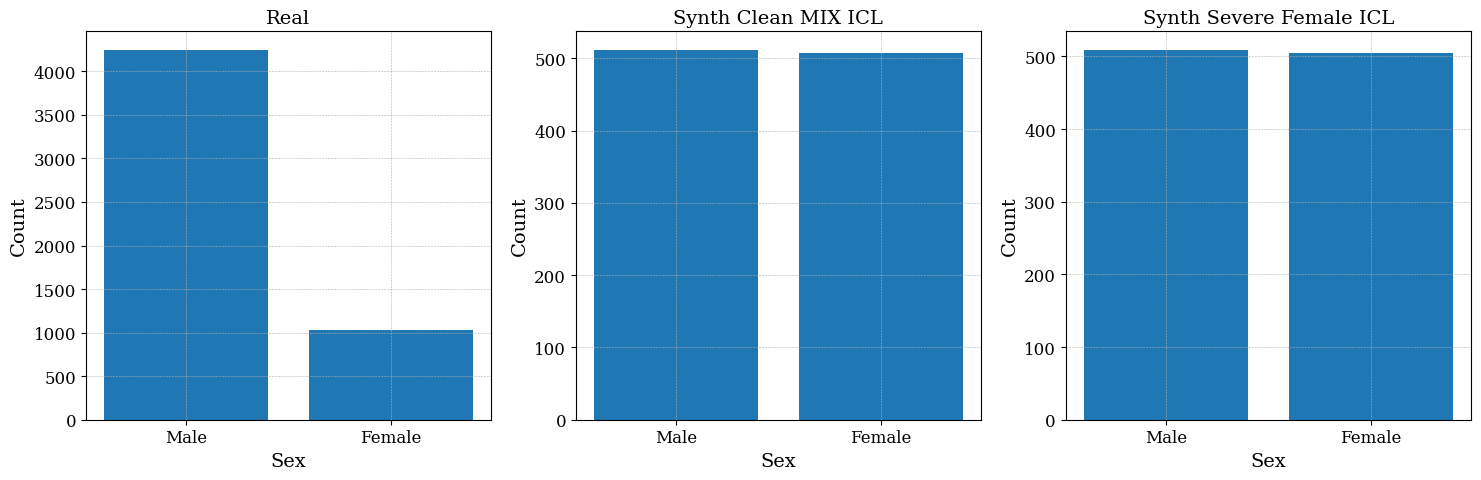

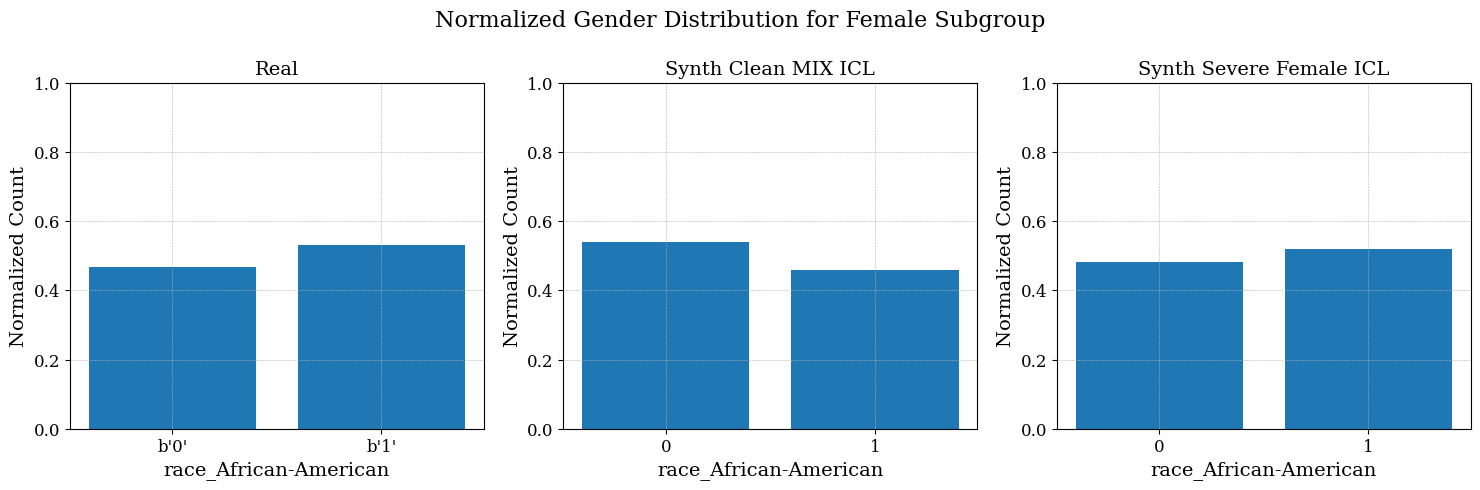

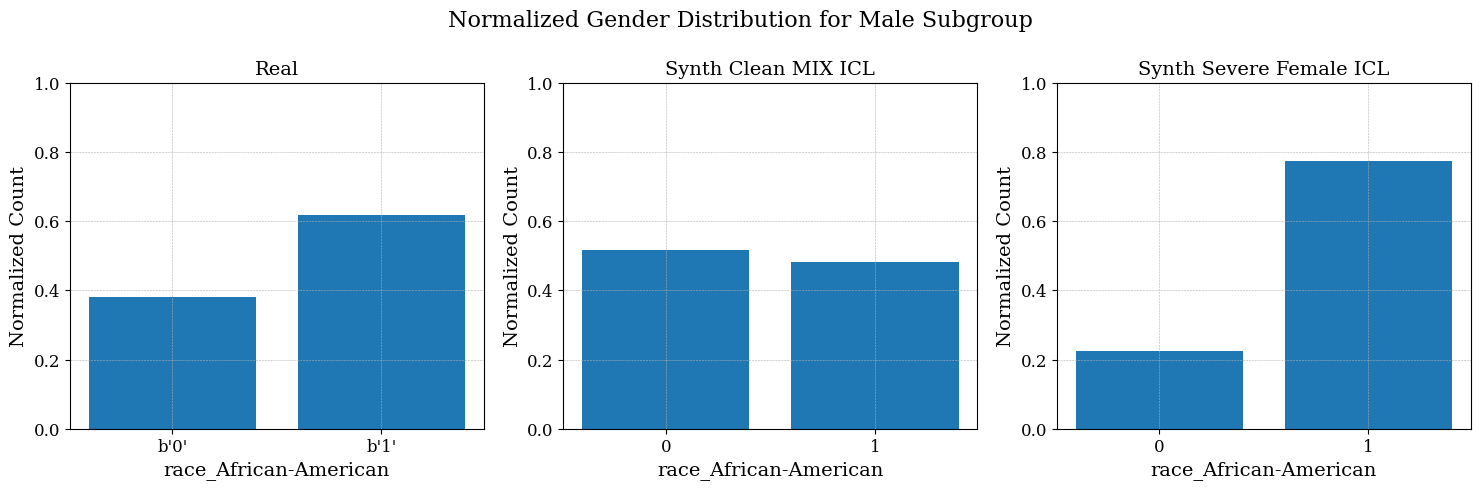

In [28]:
import matplotlib.pyplot as plt

# Dataset dictionary
datasets = {
    "Real": df_real,
    "Synth Clean MIX ICL": df_synth_clean_mix,
    "Synth Severe Female ICL": df_synth_severe,
}

gender_order = ["Male", "Female"]
n_dfs = len(datasets)

print(df_real['sex'])
print(df_synth_clean_mix["sex"])

# ---------- Plot 1: Gender Counts ----------
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))
if n_dfs == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, datasets.items()):
    counts = df['sex'].value_counts().reindex(gender_order).fillna(0)
    ax.bar(counts.index, counts.values)
    ax.set_title(label)
    ax.set_xlabel("Sex")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# ---------- Plot 2: Normalized 'y' Distributions for Female Subgroup ----------
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))
if n_dfs == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, datasets.items()):
    df_female = df[df['sex'] == "Female"]
    counts = df_female['race_African-American'].value_counts().sort_index()
    counts_norm = counts / counts.sum()
    ax.bar(counts_norm.index.astype(str), counts_norm.values)
    ax.set_title(label)
    ax.set_xlabel("race_African-American")
    ax.set_ylabel("Normalized Count")
    ax.set_ylim(0, 1)

fig.suptitle("Normalized Gender Distribution for Female Subgroup", fontsize=16)
plt.tight_layout()
plt.show()

# ---------- Plot 3: Normalized 'y' Distributions for Male Subgroup ----------
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))
if n_dfs == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, datasets.items()):
    df_male = df[df['sex'] == "Male"]
    counts = df_male['race_African-American'].value_counts().sort_index()
    counts_norm = counts / counts.sum()
    ax.bar(counts_norm.index.astype(str), counts_norm.values)
    ax.set_title(label)
    ax.set_xlabel("race_African-American")
    ax.set_ylabel("Normalized Count")
    ax.set_ylim(0, 1)

fig.suptitle("Normalized Gender Distribution for Male Subgroup", fontsize=16)
plt.tight_layout()
plt.show()